### Poisson

**In reality, poisson distribution performs more like zero-inflated poisson distribution**        
**Many smaller valued samples**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import scipy.stats as stats
import pymc3 as pm
import arviz as az
sns.set()

#### 1. The poisson PMF

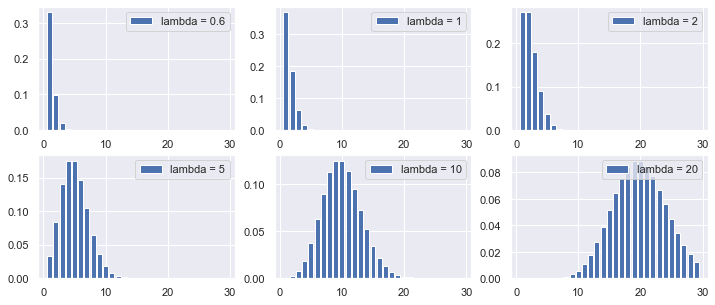

In [2]:
figsize(12,5)
for i, lam in enumerate([0.6,1,2,5,10,20]):
    plt.subplot(2,3,i+1)
    vals = np.arange(1,30)
    probs = [stats.poisson(lam).pmf(i) for i in vals]
    plt.bar(vals, probs, label = 'lambda = {}'.format(lam))
    plt.legend(loc = 'upper right')
plt.show()

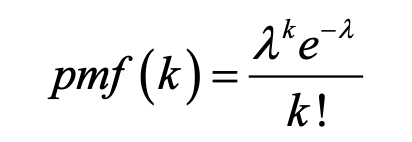

当k = 0的时候，$pmf(0) = e^{-\lambda}$    
真实的柏松分布中，我们经常遇到0非常多的情况   
$y = 1 - \phi + \phi * e^{-\lambda}$

#### How the data is generated

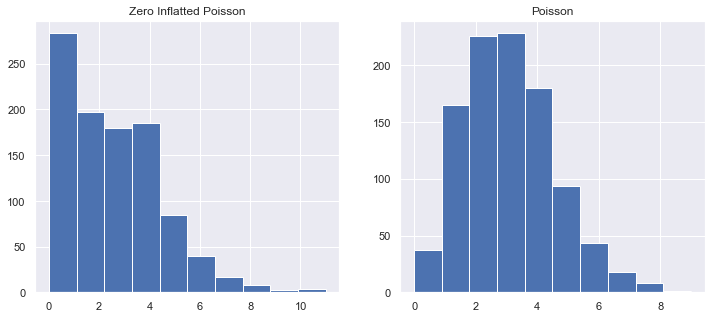

In [3]:
N = 1000
phi = 0.1
lam = 3

plt.subplot(1,2,1)
data = (np.random.random(N) > phi).astype(int) * stats.poisson(lam).rvs(N)
plt.hist(data)
plt.title('Zero Inflatted Poisson')

plt.subplot(1,2,2)
plt.hist(stats.poisson(lam).rvs(N))
plt.title('Poisson')
plt.show()

#### Zero inflated model with pymc(may be wrong)

In [4]:
idx = np.arange(len(data))
with pm.Model() as model:
    phi = pm.Beta('phi',1,1)
    p = pm.Beta('p',1,1, shape = N)
    lam = pm.Exponential('lam', 1/4)
    lamb_zero = pm.math.switch(p > phi, 0, lam)
    obs = pm.Poisson('obs', lamb_zero, observed = data)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(30000, return_inferencedata = True, start = start, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lam]
>Metropolis: [p]
>Metropolis: [phi]


Sampling 4 chains for 1_000 tune and 30_000 draw iterations (4_000 + 120_000 draws total) took 74 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


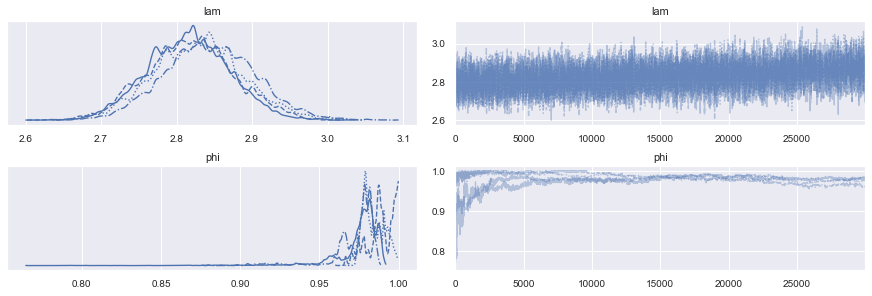

In [31]:
az.plot_trace(trace, var_names = ['lam','phi'])
plt.show()

In [5]:
az.summary(trace, var_names = ['lam','phi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam,2.797,0.059,2.688,2.908,0.012,0.009,24.0,175.0,1.10
phi,0.984,0.014,0.962,1.000,0.006,0.005,5.0,15.0,2.54


#### Posterior Predictive Checks

In [6]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["lam", "phi", "obs"], random_seed=42
    )

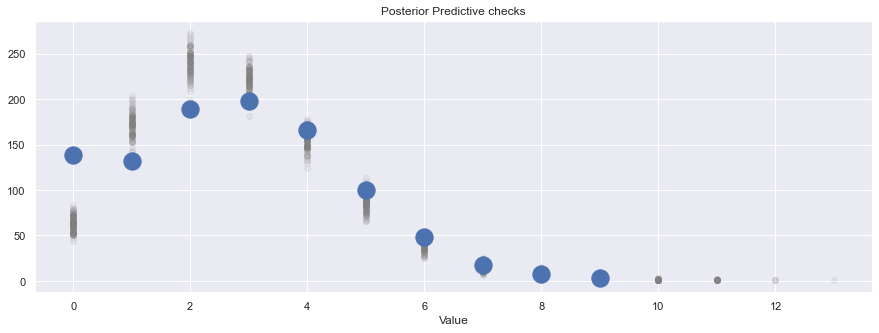

In [7]:
figsize(15,5)
for s in ppc['obs'][-100:]:
    val, cnt = np.unique(s, return_counts = True)
    plt.scatter(val, cnt, color = 'gray', alpha = .1)
val, cnt = np.unique(data, return_counts = True)
plt.scatter(val, cnt, s = 300)
plt.title('Posterior Predictive checks')
plt.xlabel('Value')
plt.show()

### Zero Inflated Poisson comes with PYMC

In [30]:
with pm.Model() as model:
    psi = pm.Beta('psi',1,1)
    lam = pm.Gamma('lam',1, 0.1)
    obs = pm.ZeroInflatedPoisson('obs', psi, lam,observed = data)
    step = pm.Metropolis()
    trace = pm.sample(1000, return_inferencedata = True, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lam]
>Metropolis: [psi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [32]:
az.summary(trace, var_names = ['lam','psi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam,3.055,0.062,2.947,3.179,0.004,0.002,300.0,375.0,1.03
psi,0.903,0.012,0.880,0.924,0.001,0.000,472.0,513.0,1.01


In [33]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["lam", "psi", "obs"], random_seed=42
    )

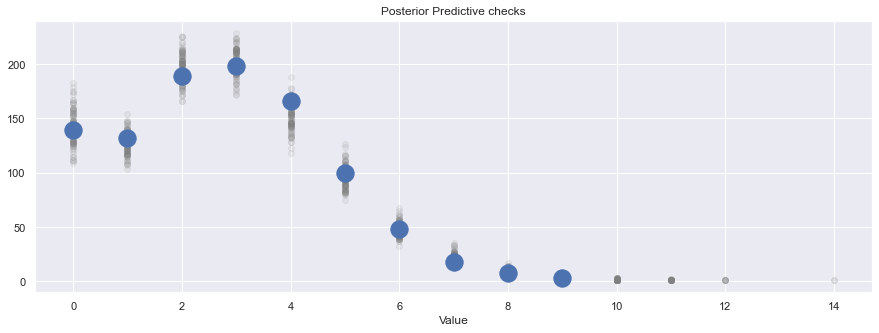

In [34]:
figsize(15,5)
for s in ppc['obs'][-100:]:
    val, cnt = np.unique(s, return_counts = True)
    plt.scatter(val, cnt, color = 'gray', alpha = .1)
val, cnt = np.unique(data, return_counts = True)
plt.scatter(val, cnt, s = 300)
plt.title('Posterior Predictive checks')
plt.xlabel('Value')
plt.show()

### Cool~  真实世界的长尾多0离散分布!!!!!!!

### Example Fish count - influenced by child and camp

In [35]:
import requests

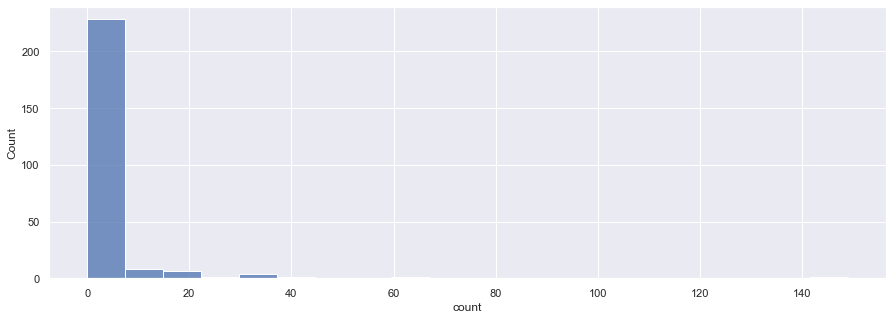

In [76]:
resp = requests.get('https://stats.idre.ucla.edu/stat/data/fish.dat')
with open('fish.csv','wb') as f:
    f.write(resp.content)
fish = pd.read_csv('fish.csv', header = None)
fish.columns = ['nofish' ,'livebait', 'camper' ,'persons', 'child', 'xb' ,'zg' ,'count']
sns.histplot(fish['count'], bins = 20)
plt.show()

这个极其偏的直方图说明，大多数人，都是钓不到鱼的

In [105]:
fish

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1
...,...,...,...,...,...,...,...,...
245,1,1,1,2,0,-0.755236,2.324209,0
246,0,1,1,4,3,1.794859,-5.625944,0
247,0,1,1,2,1,-0.392649,0.677275,0
248,1,1,1,3,2,1.374641,-2.595630,0


#### Descriptive analysis of child and camp

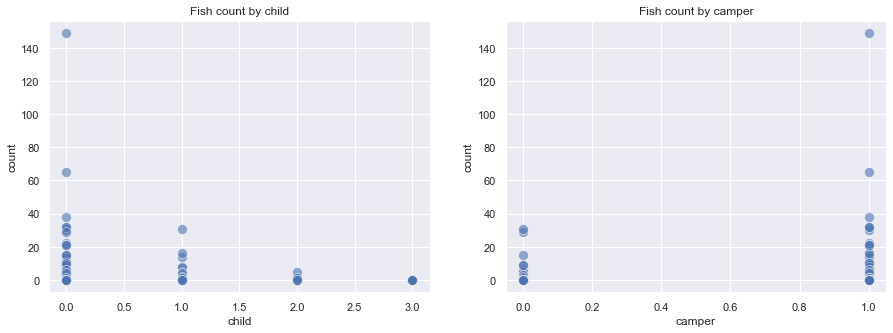

In [77]:
plt.subplot(1,2,1)
sns.scatterplot(x = fish['child'], y = fish['count'],s = 100, alpha = 0.6)
plt.title("Fish count by child")
plt.subplot(1,2,2)
sns.scatterplot(x = fish['camper'], y = fish['count'],s = 100, alpha = 0.6)
plt.title("Fish count by camper")
plt.show()

鱼的数量，是一个离散的分布，单位时间（1次游玩？）钓鱼的数量，离散分布，用泊松啊。                           
泊松分布的参数不知道，用其他的变量搞。                 
泊松分布参数受到小孩和帐篷的影响。                  
先把这俩东西的分布表示出来，然后线性一下。          
线性出来的东西可能小于0，指数一下。                            
出来的东西作为泊松分布的参数，输入到泊松里面，万事大吉         

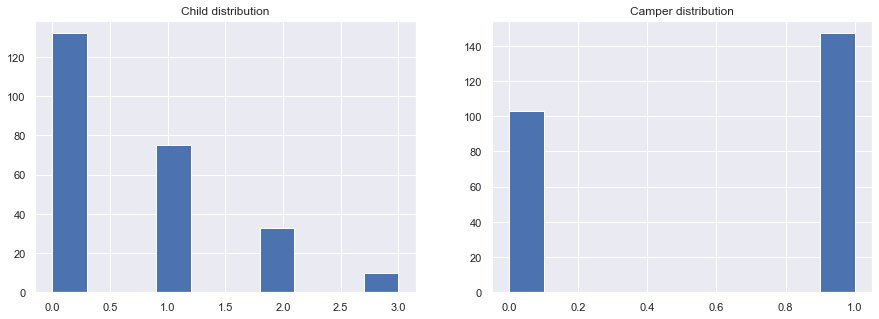

In [84]:
plt.subplot(1,2,1)
plt.hist(fish.child)
plt.title('Child distribution')
plt.subplot(1,2,2)
plt.hist(fish['camper'])
plt.title('Camper distribution')
plt.show()

### Model Structure

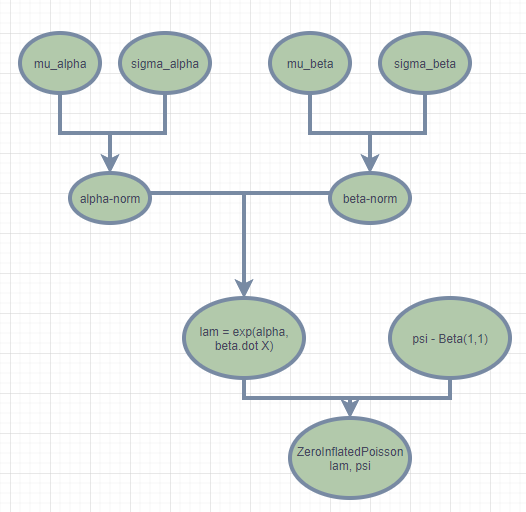

In [99]:
X = fish[['child','camper']].values
y_true = fish['count'].values

In [107]:
with pm.Model() as model:
    psi = pm.Beta('psi',1,1)
    alpha = pm.Normal('alpha',0, 10)
    beta = pm.Normal('beta',0,10, shape = (1,2))
    
    lam = pm.math.exp(alpha + pm.math.dot(beta, X.T))
    y = pm.ZeroInflatedPoisson('y', psi = psi, theta = lam, observed = y_true)
    
    trace = pm.sample(10000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, psi]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 41 seconds.
The acceptance probability does not match the target. It is 0.9033011825870648, but should be close to 0.8. Try to increase the number of tuning steps.


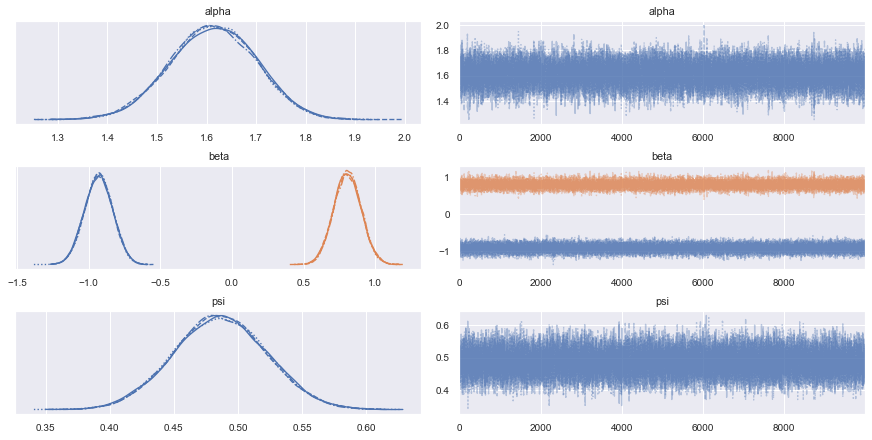

In [109]:
az.plot_trace(trace)
plt.show()

In [110]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.613,0.087,1.452,1.776,0.001,0.0,19251.0,21251.0,1.0
"beta[0,0]",-0.931,0.097,-1.113,-0.750,0.001,0.0,29957.0,25815.0,1.0
"beta[0,1]",0.806,0.095,0.627,0.982,0.001,0.0,18491.0,21425.0,1.0
psi,0.486,0.036,0.418,0.553,0.000,0.0,31761.0,25414.0,1.0


In [118]:
beta_vector = az.summary(trace.posterior['beta'])['mean'].values

In [119]:
az.summary(trace.posterior['alpha'])['']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.613,0.087,1.452,1.776,0.001,0.0,19251.0,21251.0,1.0


In [120]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["alpha", "beta",'psi', "y"], random_seed=42
    )

In [123]:
ppc['y'].shape

(40000, 1, 250)

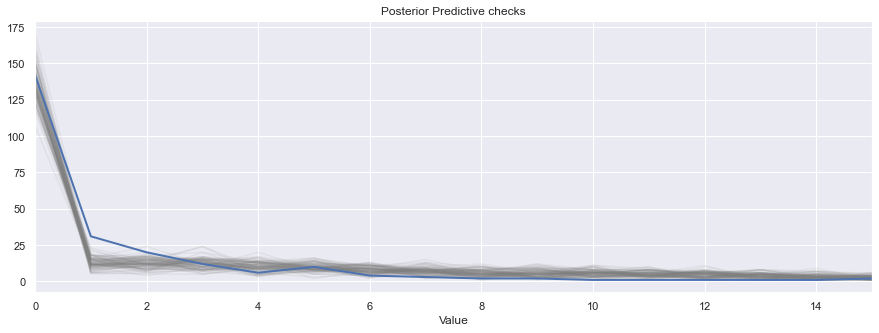

In [140]:
figsize(15,5)
for s in ppc['y'][-100:]:
    val, cnt = np.unique(s, return_counts = True)
    plt.plot(val, cnt, color = 'gray', alpha = .1)
val, cnt = np.unique(y_true, return_counts = True)
plt.plot(val, cnt, lw = 2)
plt.title('Posterior Predictive checks')
plt.xlabel('Value')
plt.xlim(0,15)
plt.show()

*Something is wrong with my impelementation......Ah....*

This is the equation from pymc3

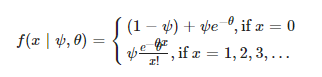

*Add something like mixture model*

https://docs.pymc.io/api/distributions/mixture.html

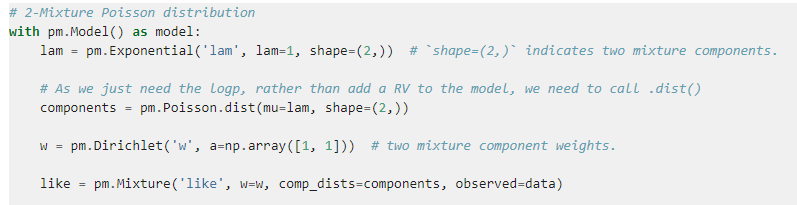

#### Using a mixture model - Two Poisson distributions instead of 1

In [54]:
with pm.Model() as model:
    psi = pm.Dirichlet('psi',a = [1,1])
    
    lam = pm.Normal('lam',mu = 2.71, sigma = 5, shape = (2,))
    
    components = pm.Poisson.dist('components', lam, shape = (2,))
    like = pm.Mixture('like', w = psi, comp_dists = components, observed = data)
    trace = pm.sample(10000, return_inferencedata = True)

ValueError: Length of components ~ Poisson cannot be determined

In [51]:
trace.posterior['lam'].shape

(4, 10000, 2)

In [45]:
psi.random()

array([0.93565573, 0.06434427])

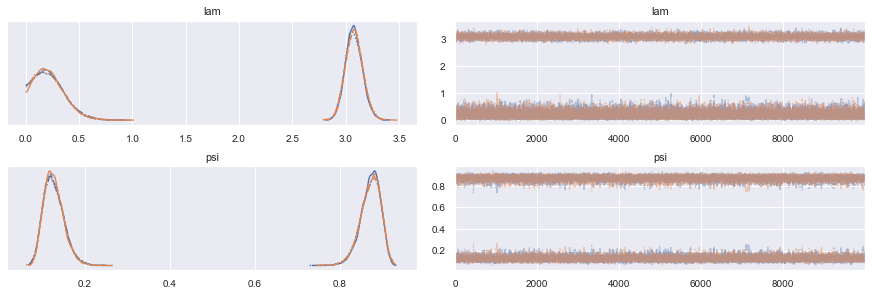

In [46]:
az.plot_trace(trace)
plt.show()

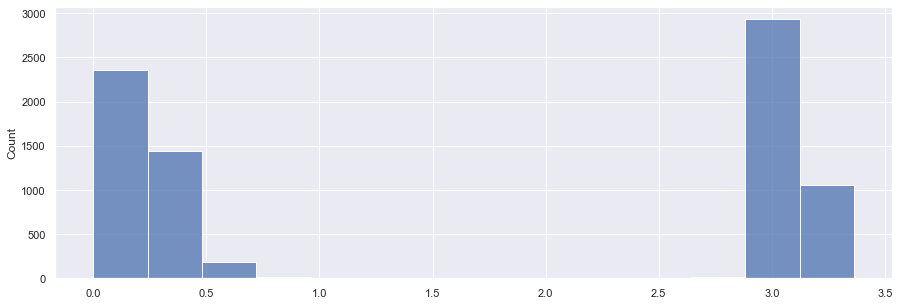

In [47]:
sns.histplot(trace.posterior['lam'][:,8000:,1].values.reshape(-1))

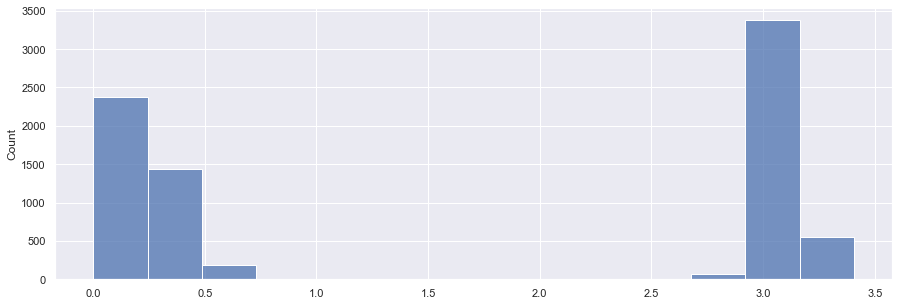

In [48]:
sns.histplot(trace.posterior['lam'][:,8000:,0].values.reshape(-1))

In [49]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam[0],1.651,1.431,0.019,3.188,0.713,0.546,6.0,100.0,1.73
lam[1],1.652,1.432,0.019,3.187,0.713,0.547,6.0,97.0,1.73
psi[0],0.500,0.374,0.094,0.906,0.186,0.143,6.0,93.0,1.73
psi[1],0.500,0.374,0.094,0.906,0.186,0.143,6.0,93.0,1.73


In [14]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["lam",'psi', "like"], random_seed=42
    )

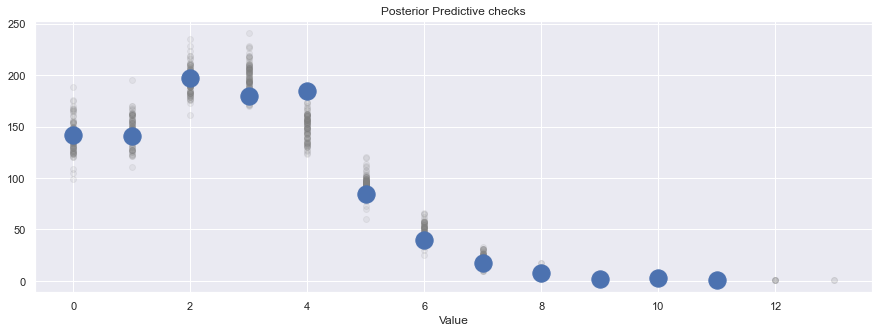

In [15]:
figsize(15,5)
for s in ppc['like'][-100:]:
    val, cnt = np.unique(s, return_counts = True)
    plt.scatter(val, cnt, color = 'gray', alpha = .1)
val, cnt = np.unique(data, return_counts = True)
plt.scatter(val, cnt, s = 300)
plt.title('Posterior Predictive checks')
plt.xlabel('Value')
plt.show()